<a href="https://colab.research.google.com/github/rohankilledar/Arckin/blob/master/cw1_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework 1: Train a Sentiment Analysis Classifier
In this course work, you are asked to train a sentiment analysis classifier for movie reviews. The sample code below builds a simple classifier that uses tf-idf to vectorize text and a logistic regression model to make predictions.

# New Section

In [1]:
# load data and take a quick look

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
filepath='/content/drive/MyDrive/Royal Holloway AI/NLP/coursework1_train.csv'
raw_data = pd.read_csv(filepath)

raw_data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,text,sentiment
0,0,Enjoy the opening credits. They're the best th...,neg
1,1,"Well, the Sci-Fi channel keeps churning these ...",neg
2,2,It takes guts to make a movie on Gandhi in Ind...,pos
3,3,The Nest is really just another 'nature run am...,neg
4,4,Waco: Rules of Engagement does a very good job...,pos


In [2]:
# check the size of the data and its class distribution
all_text = raw_data['text'].tolist()
all_lables = raw_data['sentiment'].tolist()

print('entry num', len(all_text))
print('num of pos entries', len([l for l in all_lables if l=='pos']))
print('num of neg entries', len([l for l in all_lables if l=='neg']))



entry num 40000
num of pos entries 20000
num of neg entries 20000


In [3]:
# text cleaning and preprocessing:
# This sample code does not perform any text normalization/pre-processing
# Feel free to apply any pre-processing steps you find appropriate

# Lower case all the text to avoid mismatch
all_text = [words.lower() for words in all_text]

#tokenizing the sentences into words using nltk word tokenizer 
import nltk
#check if required resource is available or not and if not then install it.
try:
  nltk.data.find('tokenizers/punkt')
except LookupError:
  nltk.download('punkt')
from nltk.tokenize import word_tokenize

#list of tokenized words from the entire text list
tokenized_sents = [word_tokenize(i) for i in all_text]


Now that we have tokenized the words, we can remove the stopwords and punctuation mark from them as they are not useful for computers/classifer

In [4]:
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
en_stopwords = stopwords.words('english')
#adding some additional stopwords that we observed in text to list of stopwords 
new_stopwords = ['--','`',"'",'``', "''","'s",'br','...',"'re"]
en_stopwords.extend(new_stopwords)

#clean text is a nested list of clean reviews 
clean_text = []

for review in tokenized_sents:
  tokenized_sents_wo_sw = [word for word in review if word not in en_stopwords and word not in string.punctuation]
  clean_text.append(tokenized_sents_wo_sw)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


we can also lemmatize the words to find the basic form of word that means the same thing 

In [5]:
from nltk.stem import WordNetLemmatizer
#check if required resource is available or not and if not then install it.
try:
  nltk.data.find('corpora/wordnet')
except LookupError:
  nltk.download('wordnet')  
lemmatizer = WordNetLemmatizer()

lemmatized_clean_text=[] 
#all clean text is a list of all the words from all the reviews
all_clean_text = []

for review in clean_text:
  lemm = [lemmatizer.lemmatize(word) for word in review]
  lemmatized_clean_text.append(lemm)
  all_clean_text.extend(lemm)

Let's make a function of this preprocessing of data for easier use later.

In [6]:
def preprocessing(sentence, stopwords_list = en_stopwords, lemma = lemmatizer):
  clean_word = []
  for word in sentence:
    word = word.lower()
    if word not in stopwords_list and word not in string.punctuation:
      clean_word.append(lemma.lemmatize(word))
  return clean_word

In [7]:
cw = preprocessing(tokenized_sents[0])

Lets have a visual look at how our list of words look using wordcloud

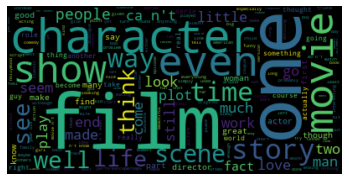

In [8]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
# Create and generate a word cloud image:
wordcloud = WordCloud().generate((" ").join(all_clean_text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

now that we have the clean data, we can do some analysis of the data.

In [9]:
from nltk import FreqDist
# i figured some stopwords using this and removed them in the previous step, I think We can use this before removing stopwords to find more stopwords
all_words_frequency = FreqDist(all_clean_text)
all_words_frequency.most_common(15)


[('movie', 79799),
 ('film', 72013),
 ("n't", 52853),
 ('one', 42759),
 ('like', 31990),
 ('time', 23573),
 ('good', 23136),
 ('character', 22269),
 ('would', 21191),
 ('even', 19788),
 ('story', 19443),
 ('get', 19434),
 ('see', 18849),
 ('make', 18749),
 ('really', 18348)]

In [10]:
print("Total number of unique words: "+ str(len(all_words_frequency)))
# get 2000 frequently occuring words
most_common_words = all_words_frequency.most_common(2000)
word_features = [item[0] for item in most_common_words]
print (word_features[:10])

Total number of unique words: 140129
['movie', 'film', "n't", 'one', 'like', 'time', 'good', 'character', 'would', 'even']


lets use bag of words to create feature set for our Naive Bayese classifier

In [11]:
from nltk import ngrams

# feature extractor function for unigram
def bag_of_words(words):	
	words_dictionary = dict([word, True] for word in words)	
	return words_dictionary


#when using bi-grams, there are some stopwords that makes sense in a sentence in context to other words like "It was a very good movie"
#stopword 'very' is important for bigram so lets use a different set of stopwords for bigram

en_stopwords_for_bigram = set(en_stopwords) - {'very','over','under','above','below','more','less','no','nor','not','never','only'}

# feature extractor function for ngrams (unigram)
def bag_of_ngrams(words, n=2):
	words_ng = []
	for item in iter(ngrams(words, n)):
		words_ng.append(item)
	words_dictionary = dict([word, True] for word in words_ng)	
	return words_dictionary

 #  let's define a new function that extracts all features
# i.e. that extracts both unigram and bigrams features
def bag_of_all_words(words, n=2):
	words_clean = preprocessing(words, en_stopwords)
	words_clean_for_bigrams = preprocessing(words, en_stopwords_for_bigram)

	unigram_features = bag_of_words(words_clean)
	bigram_features = bag_of_ngrams(words_clean_for_bigrams)

	all_features = unigram_features.copy()
	all_features.update(bigram_features)

	return all_features

In [12]:
# bag_of_words(preprocessing(tokenized_sents[0]))
# bag_of_ngrams(preprocessing(tokenized_sents[0]))
# bag_of_all_words(preprocessing(tokenized_sents[0]))

In [13]:
pos_r = raw_data.loc[raw_data['sentiment'] == 'pos']
pos_review=pos_r['text'].tolist()

neg_r = raw_data.loc[raw_data['sentiment'] == 'neg']
neg_review=neg_r['text'].tolist()



In [14]:
# positive reviews feature set
pos_review_set = []
for words in pos_review:
	pos_review_set.append((bag_of_all_words(word_tokenize(words.replace(".", " "))), 'pos'))
 
 #after tokenizing and preprocessing data, I figured the .(dot) is not getting tokenized 
 #and joining few words like watch.brilliant and wrong.this

# # negative reviews feature set
neg_review_set = []
for words in neg_review:
	neg_review_set.append((bag_of_all_words(word_tokenize(words.replace("."," "))), 'neg'))

We have 20000 positive and 20000 negative review each. We can divide them in the ratio of 70:30 for training and testing dataset.

In [15]:
train_set = pos_review_set[:14000] + neg_review_set[:14000]
test_set = pos_review_set[14000:] + neg_review_set[14000:]

Now that we have our training and test set of all positive and negative feature set, we can apply classifier to it

In [17]:
from nltk import classify
from nltk import NaiveBayesClassifier
import nltk.metrics as met

#initializing the classifier object
NBclassifier = NaiveBayesClassifier.train(train_set)

accuracy = classify.accuracy(NBclassifier,test_set)
print("acc "+ str(accuracy))

#we can check the most informative features that the classifier determined to label the test set
print(NBclassifier.show_most_informative_features(10))


acc 0.88675
Most Informative Features
   ('movie', 'horrible') = True              neg : pos    =     52.3 : 1.0
  ('acting', 'horrible') = True              neg : pos    =     48.3 : 1.0
   ('possibly', 'worst') = True              neg : pos    =     47.0 : 1.0
      ('worst', 'movie') = True              neg : pos    =     43.1 : 1.0
      ('total', 'waste') = True              neg : pos    =     40.3 : 1.0
   ('terrible', 'movie') = True              neg : pos    =     40.2 : 1.0
       ('avoid', 'cost') = True              neg : pos    =     39.4 : 1.0
                    boll = True              neg : pos    =     38.3 : 1.0
                    3/10 = True              neg : pos    =     37.9 : 1.0
                    7/10 = True              pos : neg    =     36.8 : 1.0
None


Let's test our classifier using some custom reviews

In [35]:
#test_review = word_tokenize(neg_review[5].replace("."," "))
custom_review1 = "Captain America getting Thor's hammer was the highlight of the movie and it was shocking and surprising"
test_review1 = word_tokenize(custom_review1)
test_review_set1 = bag_of_all_words(test_review1)
print("Custom Review1: "+custom_review1)
print(NBclassifier.classify(test_review_set1))

#custom_review2 = " the movie was a bit off and too obvious"
#custom_review2= test_text[7]
custom_review2="I was not able to take off my eyes all the time. It kept me hooked for a long time. I was also googling things about it after it was over"
test_review2 = word_tokenize(custom_review2)
test_review_set2 = bag_of_all_words(test_review2)
print("Custom Review2: "+custom_review2)
print(NBclassifier.classify(test_review_set2))

Custom Review1: Captain America getting Thor's hammer was the highlight of the movie and it was shocking and surprising
pos
Custom Review2: what's inexplicable? firstly, the hatred towards this movie. it may not be the greatest movie of all time, but gimme a break, it got 11 oscars for a reason, it made eighteen hundred million dollars for a reason. it's a damn good movie. which brings to the other inexplicable aspect of it. i have no idea whatsoever why this movie left such an impression on me when i saw it in theaters. i've rewatched it on tv and video, and it had none of the impact it had when i saw it on the big screen (twice, or maybe three times, actually). but that might be it, the appeal of it. it's a movie, yes, capital m there, it's an epic, it's a spectacle in the order of gone with the wind or ben hur. now, ben hur and gone with the wind seem kinda hokey to me, with the hammy acting and excessive melodrama. not that titanic has none of that. well, the acting was actually ve

When the classifier was trained using unigram features the accuracy was less compared to the combined feature set.


In [19]:
# data split. 
# Feel free to use differnt ratios or strategies to split the data.
train_text = all_text[:35000]
train_labels = all_lables[:35000]
test_text = all_text[35000:]
test_labels = all_lables[35000:]

In [20]:
# training: tf-idf + logistic regression
# you should explore different representations and algorithms.
from sklearn.feature_extraction.text import TfidfVectorizer
max_feature_num = 1000
train_vectorizer = TfidfVectorizer(max_features=max_feature_num)
train_vecs = train_vectorizer.fit_transform(train_text)
test_vecs = TfidfVectorizer(max_features=max_feature_num,vocabulary=train_vectorizer.vocabulary_).fit_transform(test_text)

# train model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(train_vecs, train_labels)

# test model
test_pred = clf.predict(test_vecs)
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
acc = accuracy_score(test_labels, test_pred)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, test_pred, average='macro')
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

acc 0.8616
precision 0.8616043455692743
rec 0.8615913854621674
f1 0.8615956596398864


## SAVE YOUR TRAINED MODEL
After you have found the best model, save your trained model and other necessary components (e.g. vocabulary, vectorizer) to a file. We will load your model from the saved file and apply your trained model on some held-out test data. **At submission time, you should submit the saved model file and we will NOT re-run your code to train your model; instead, we will directly use your trained model to run test (see notebook *cw1-test.ipynb*)**. 

Below is a sample code for saving the model (and other necessary components) obtained above, using the *pickle* package in Python. *You should adjust the code to save all the necessary components for re-running your model!*

In [36]:
import pickle

# save model and other necessary modules
all_info_want_to_save = {
    'model': clf,
    'vectorizer': TfidfVectorizer(max_features=max_feature_num,vocabulary=train_vectorizer.vocabulary_),
    'classifier': NBclassifier,
    'pos_feature_set': pos_review_set,
    'neg_feature_set': neg_review_set
}

with open("sample_trained_model.pickle","wb") as save_path:
    pickle.dump(all_info_want_to_save, save_path)

In *cw1-test.ipynb*, we provide a sample code to illustrate how to re-load your saved model and apply it to some test data. 